In [1]:
import sys, os
import sparse
import xsimlab as xs
import numpy as np
import pandas as pd
import igraph as ig
from pgljupyter import SceneWidget

In [2]:
sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import vmlab
from vmlab.models.vmango import vmango as model
from vmlab.enums import Nature, Position

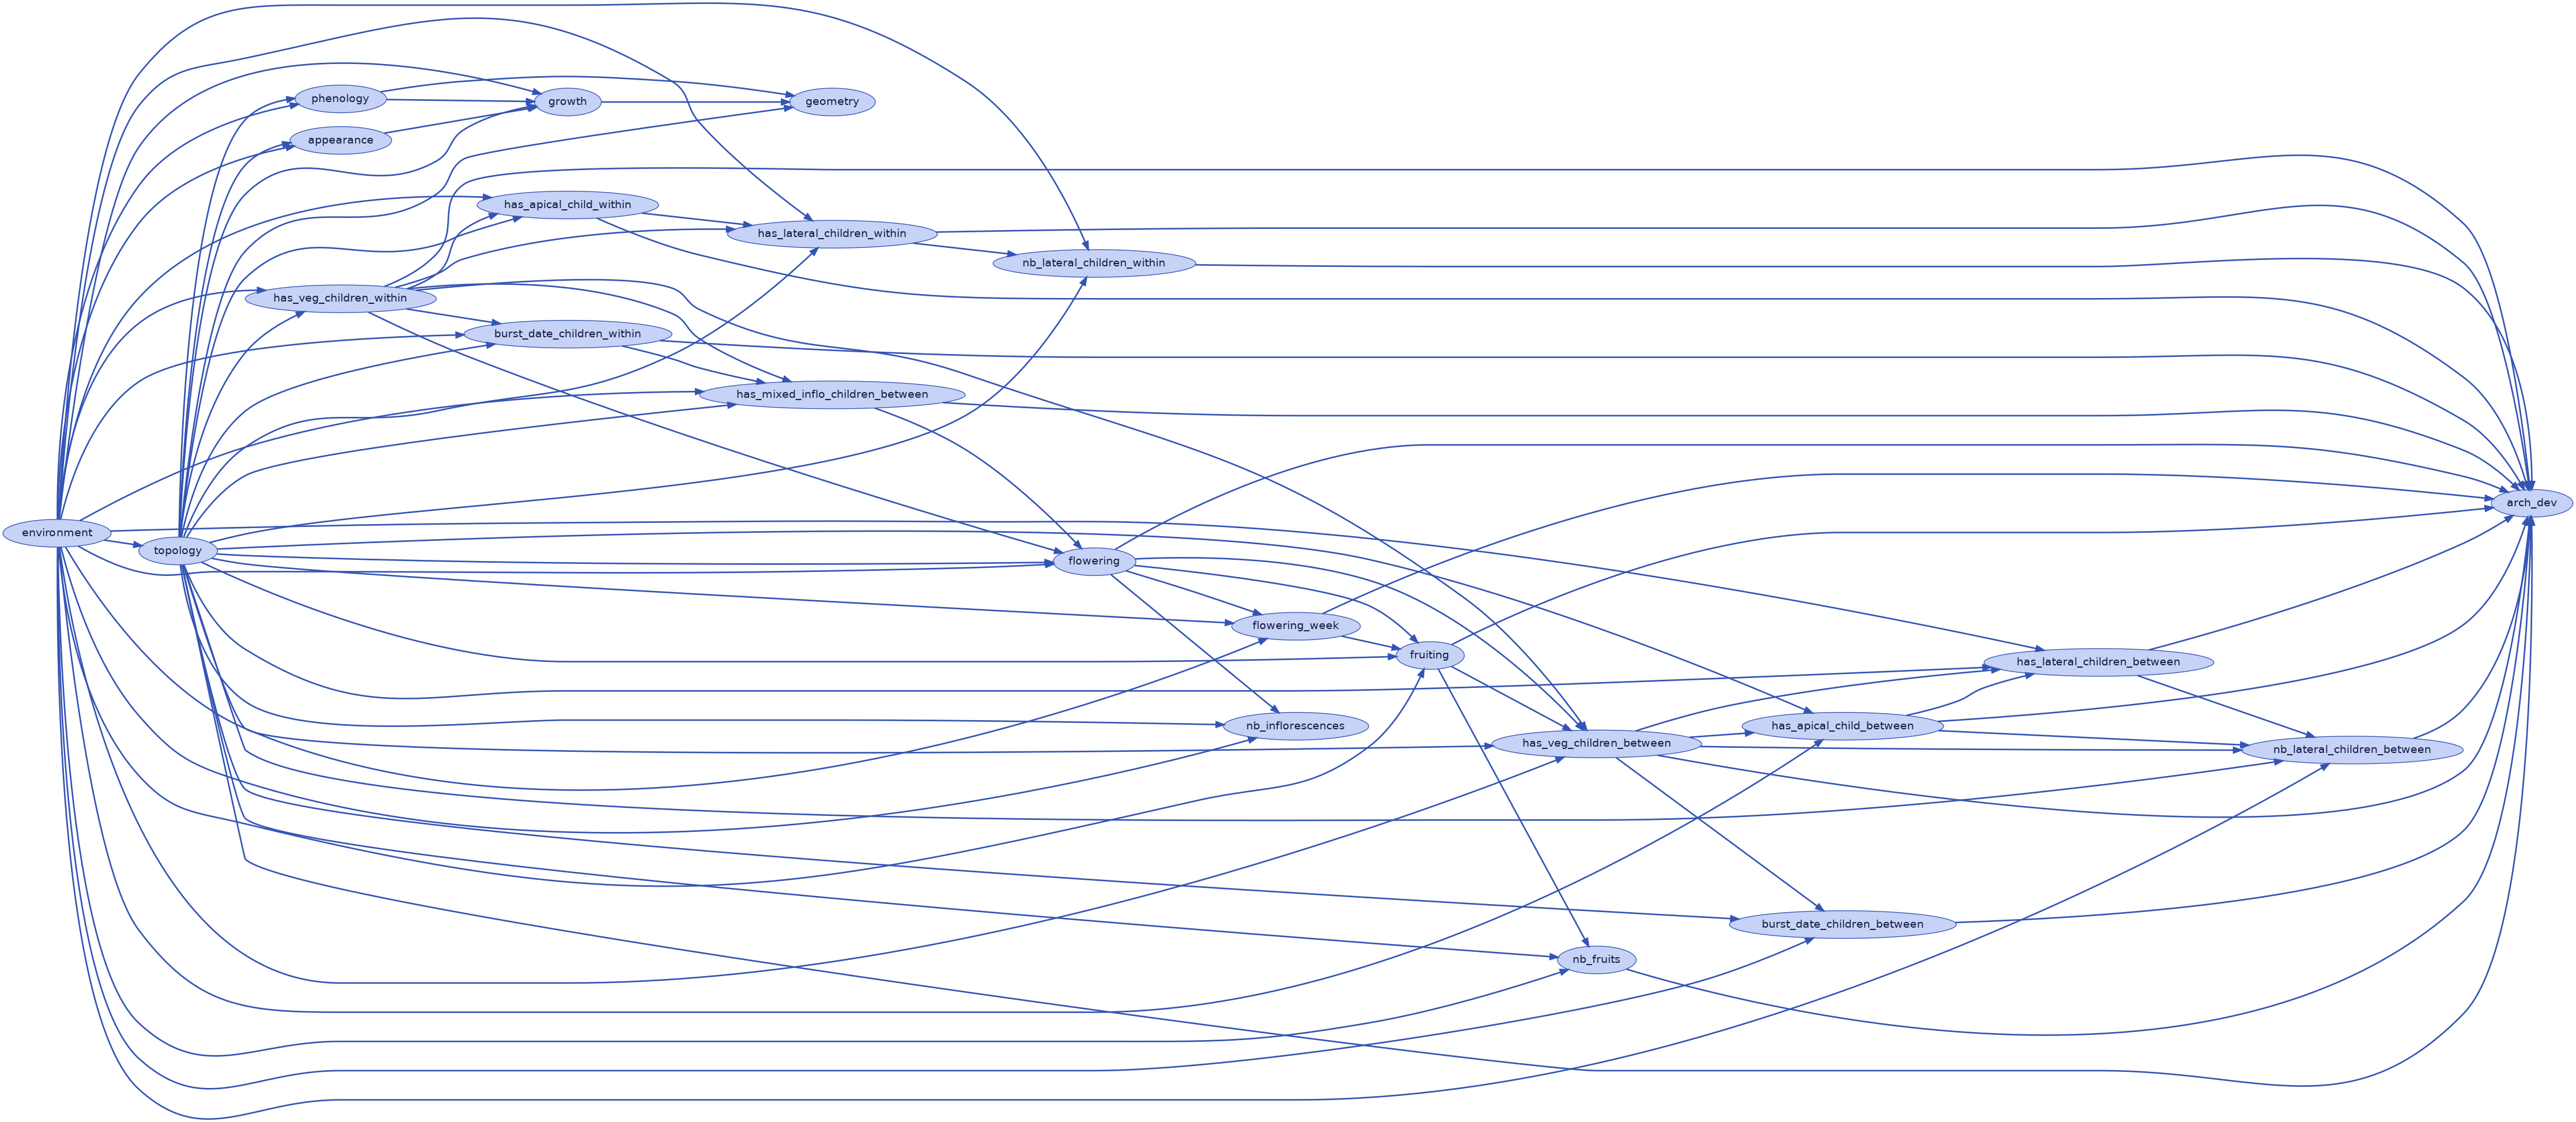

In [3]:
model.visualize()

In [4]:
nb_gus = 8
g = ig.Graph.Tree(nb_gus, 7, mode=ig.TREE_OUT)
adjacency = np.array(g.get_adjacency().data)

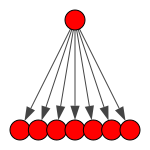

In [5]:
ig.plot(g, bbox=(0,0,150,150), layout=g.layout_reingold_tilford())

In [6]:
final_length_internodes = np.array([None] * nb_gus, dtype=object)
final_length_leaves = np.array([None] * nb_gus, dtype=object)
final_length_internodes[0] = [50]
final_length_leaves[0] = [0]
for i in range(1, nb_gus):
    final_length_internodes[i] = [40]
    final_length_leaves[i] = [0]

ds = vmlab.create_setup(
    model=model,
    setup_toml='../share/setup/vmango.toml',
    clocks={
        'day': pd.date_range(start='2002-04-01', end='2006-12-31', freq="1d")
    },
    main_clock='day',
    input_vars={
        'topology': {
            'current_cycle': 3,
            'month_begin_veg_cycle': 7,
            'doy_begin_flowering': 214,
            'adjacency': adjacency,
            'position': np.array([Position.APICAL] + ([Position.LATERAL] * (nb_gus - 2)) + [Position.APICAL])
        },
        'geometry': {
            'sampling_rate': 7
        },
        'phenology': {
            'bloom_date': np.full(nb_gus, '2002-11-01')
        },
        'arch_dev': {
            'burst_date': np.append(np.array(['2002-03-01'], dtype='datetime64[D]'), pd.date_range(start='2002-04-02', end='2002-04-30', periods=nb_gus-1).to_numpy()),
            'has_apical_child': np.ones(nb_gus),
            'nb_lateral_children': np.array([nb_gus - 1] + [4] * (nb_gus -1)),
            'nature': np.full(nb_gus, Nature.VEGETATIVE)
        },
        'appearance': {
            'final_length_internodes': final_length_internodes,
            'nb_internode': np.ones(nb_gus),
            'nb_leaf': np.zeros(nb_gus),
            'final_length_gu': np.full(nb_gus, 10),
            'final_length_leaves': final_length_leaves,
            'final_length_inflos': np.full(nb_gus, None, dtype=object)
        },
        'flowering_week': {
            'flowering_date': np.full(nb_gus, np.datetime64('NAT'), dtype='datetime64[D]')
        },
        'nb_inflorescences': {
            'nb_inflorescences': np.zeros(nb_gus)
        }
    },
    output_vars=None
)

In [7]:
sw = SceneWidget(size_world=2.5)
sw

SceneWidget(scenes=[{'id': 'UsNrhN89S9g6V0l5CBaWAUL5L', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

In [8]:
scene_ = None
@xs.runtime_hook(stage='run_step')
def hook(model, context, state):
    global scene_
    scene = state[('geometry', 'scene')]
    if scene != scene_:
        sw.set_scenes([scene], scales=[1/100])
        scene_ = scene
    
ds_out = ds.xsimlab.run(model=model, decoding={ 'mask_and_scale': False }, hooks=[xs.monitoring.ProgressBar(), hook])
ds_out

             0% | initialize 

<xarray.Dataset>
Dimensions:                                                             (GU: 219, day: 1736, hour: 24)
Coordinates:
  * GU                                                                  (GU) <U10 ...
  * day                                                                 (day) datetime64[ns] ...
  * hour                                                                (hour) int8 ...
Data variables: (12/94)
    appearance__appeared                                                (GU) float64 ...
    appearance__final_length_gu                                         (GU) int64 ...
    appearance__final_length_inflos                                     (GU) object ...
    appearance__final_length_internodes                                 (GU) object ...
    appearance__final_length_leaves                                     (GU) object ...
    appearance__nb_internode                                            (GU) float64 ...
    ...                                                                  ...
    topology__month_begin_veg_cycle                                     int64 7
    topology__nb_descendants                                            (GU) int64 ...
    topology__nb_fruit                                                  (GU) float64 ...
    topology__nb_inflo                                                  (GU) float64 ...
    topology__position                                                  (GU) float64 ...
    topology__position_parent                                           (GU) float64 ...